In [5]:
import torch
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import ToPILImage
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import random

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [3]:
#https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
 99% 98.0M/98.7M [00:01<00:00, 83.7MB/s]
100% 98.7M/98.7M [00:01<00:00, 77.4MB/s]


In [4]:
!unzip -q \*.zip && rm *.zip

In [5]:
data_set_train = []
data_set_test = []

train_beign = '/content/melanoma_cancer_dataset/train/benign'
test_beign = '/content/melanoma_cancer_dataset/test/benign'
train_malignant = '/content/melanoma_cancer_dataset/train/malignant'
test_malignant = '/content/melanoma_cancer_dataset/test/malignant'

contents1 = os.listdir(train_beign)
contents2 = os.listdir(test_beign)
contents3 = os.listdir(train_malignant)
contents4 = os.listdir(test_malignant)

for item in contents1:
  data_set_train.append((Image.open(os.path.join(train_beign, item)), 0))

for item in contents2:
  data_set_test.append((Image.open(os.path.join(test_beign, item)), 0))

for item in contents3:
  data_set_train.append((Image.open(os.path.join(train_malignant, item)), 1))

for item in contents4:
  data_set_test.append((Image.open(os.path.join(test_malignant, item)), 1))

random.shuffle(data_set_train)
random.shuffle(data_set_test)

print(len(data_set_train), len(data_set_test))

9605 1000


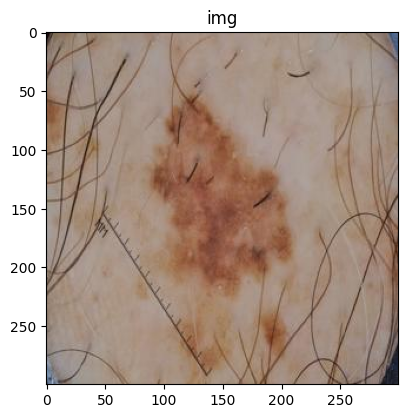

In [6]:
# Assuming data_set_train is a list of (image, label) tuples
train_img, train_label = random.choice(data_set_train)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 2, 1)
ax.imshow(train_img)
ax.set_title('img')
plt.show()

In [7]:
class SkinLesions(Dataset):
    def __init__(self, mode, data_set_train, data_set_test):
        self.mode = mode

        if self.mode == 'train':
            self.images = [item[0] for item in data_set_train]
            self.labels = [item[1] for item in data_set_train]
        elif self.mode == 'test':
            self.images = [item[0] for item in data_set_test]
            self.labels = [item[1] for item in data_set_test]
        else:
            raise ValueError('Invalid mode')

        self.transform = transforms.Compose([
            transforms.Resize((200, 200)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if isinstance(image, str):
            image = Image.open(image).convert('RGB')
        image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure label is a tensor
        return image, label

In [8]:
batch_size = 20
learning_rate = 0.001
epochs = 10

In [9]:
train_set = SkinLesions('train', data_set_train, data_set_test)
test_set = SkinLesions('test', data_set_train, data_set_test)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

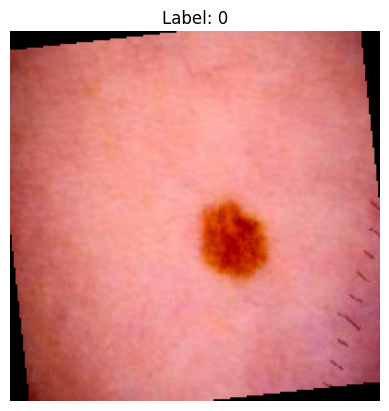

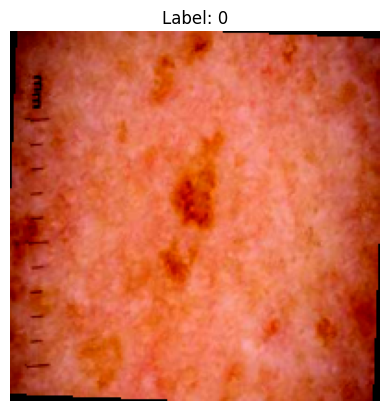

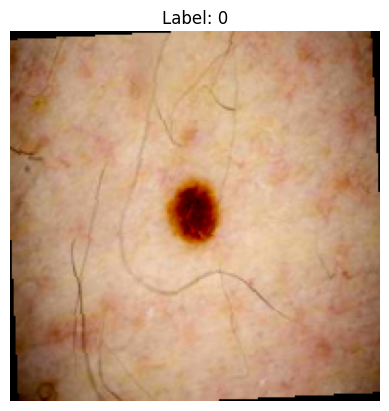

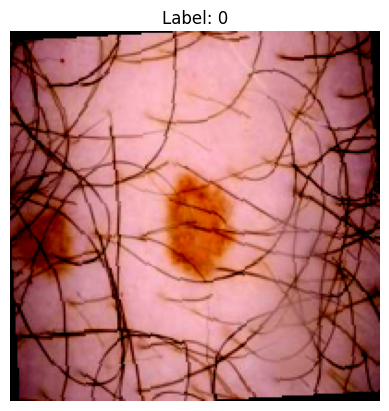

In [10]:
# Iterate over the train_dataloader
counter = 0
for idx, (images, labels) in enumerate(train_dataloader):
    # Access the first batch
    # Get the first image and label from the batch
    image = images[idx]
    label = labels[idx]


    # Convert the image tensor to a NumPy array
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Display the image using Matplotlib
    plt.imshow(image_np)
    plt.title(f'Label: {label.item()}')
    plt.axis('off')
    plt.show()
    if counter == 3:
      break
    else:
      counter = counter +1

In [6]:
class SkinLesions(nn.Module):
    def __init__(self):
        super(SkinLesions, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(160000, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        flatten = nn.Flatten()
        x = flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [12]:
model = SkinLesions().to('cuda')

In [13]:
model = model.to('cuda')
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [14]:
train_loss_per_epoch = []
for epoch in range(10):
    running_loss_train = []
    model.train()
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        optim.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optim.step()

        running_loss_train.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    avg_loss = np.mean(running_loss_train)
    accuracy = 100 * total_correct / total_samples
    train_loss_per_epoch.append(avg_loss)

    print(f'Epoch [{epoch + 1}/10], Batch Losses: {avg_loss}, Accuracy: {accuracy}')

print('Finished Training')

Epoch [1/10], Batch Losses: 0.33616194601428234, Accuracy: 85.66371681415929
Epoch [2/10], Batch Losses: 0.2824573282717791, Accuracy: 88.07912545549193
Epoch [3/10], Batch Losses: 0.2655923709722542, Accuracy: 88.70380010411245
Epoch [4/10], Batch Losses: 0.25216612482362133, Accuracy: 89.2243623112962
Epoch [5/10], Batch Losses: 0.2425702603421563, Accuracy: 89.69286829776158
Epoch [6/10], Batch Losses: 0.23444230158633228, Accuracy: 90.29672045809474
Epoch [7/10], Batch Losses: 0.22548546363249142, Accuracy: 90.76522644456013
Epoch [8/10], Batch Losses: 0.22695786663158768, Accuracy: 90.29672045809474
Epoch [9/10], Batch Losses: 0.22584870220655712, Accuracy: 90.58823529411765
Epoch [10/10], Batch Losses: 0.2187057258154647, Accuracy: 90.87975013014055
Finished Training


In [15]:
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    running_loss_test = []
    for inputs, labels in test_dataloader:
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss_test.append(loss.item())


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = np.mean(running_loss_test)

    print(f'Test Loss: {avg_loss}, Accuracy: {100 * correct / total}')



Test Loss: 0.228204225897789, Accuracy: 90.9


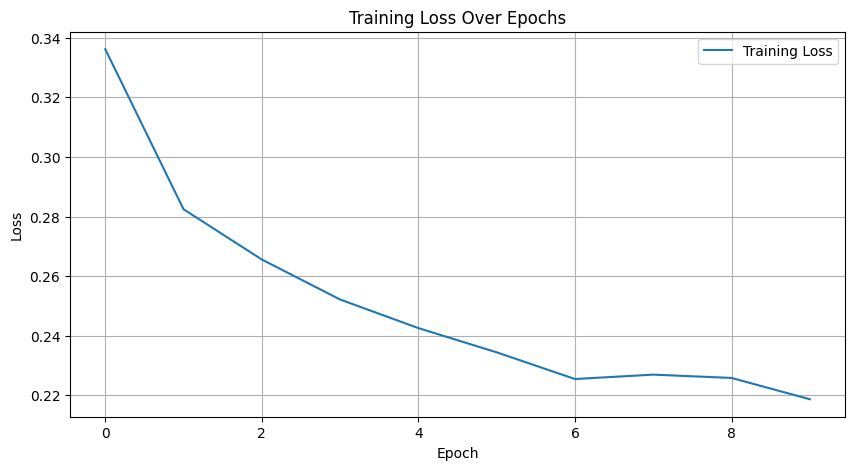

In [16]:
epochs = range(len(train_loss_per_epoch))

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_per_epoch, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optim.state_dict():
    print(var_name, "\t", optim.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
bn1.weight 	 torch.Size([32])
bn1.bias 	 torch.Size([32])
bn1.running_mean 	 torch.Size([32])
bn1.running_var 	 torch.Size([32])
bn1.num_batches_tracked 	 torch.Size([])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
bn2.weight 	 torch.Size([64])
bn2.bias 	 torch.Size([64])
bn2.running_mean 	 torch.Size([64])
bn2.running_var 	 torch.Size([64])
bn2.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([128, 160000])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([2, 128])
fc2.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {0: {'momentum_buffer': tensor([[[[ 1.0399e-01,  3.4982e-02,  4.6634e-02],
          [ 9.9428e-02,  1.8068e-02,  3.1556e-02],
          [ 9.6770e-02,  1.7678e-02,  3.0029e-02]],

         [[ 1.8940e-01,  1.6640e-01,  1.8730e-01],
          [ 1.7974e-01,  1.4639e-01,  1.6814e-01],
          [ 1.7361e-01,  1.4190e-01,  1.6197e-01]],

  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
#dont run this
torch.save(model.state_dict(), '/content/drive/MyDrive/model_weights.pth')
print("Model weights saved successfully!")

Model weights saved successfully!


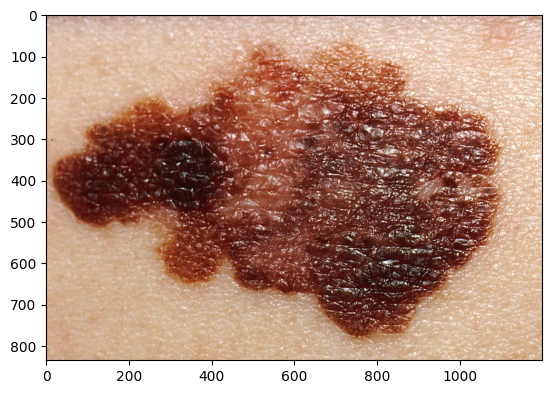

Melanoma


In [7]:
import matplotlib.pyplot as plt

#Testing image from web - Melanoma
model = SkinLesions()
model.load_state_dict(torch.load('/content/drive/MyDrive/Skin_lesions_project/model_weights.pth'))
model.eval()

image_path = '/content/drive/MyDrive/Skin_lesions_project/Melanoma.jpg' #Sample image from the web (Melanoma)
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.show()
transform = transforms.Compose([
            transforms.Resize((200, 200)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
image = transform(image)
with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, predicted = torch.max(output, 1)
    if predicted.item() == 1:
      print('Melanoma')
    else:
      print('Benign')


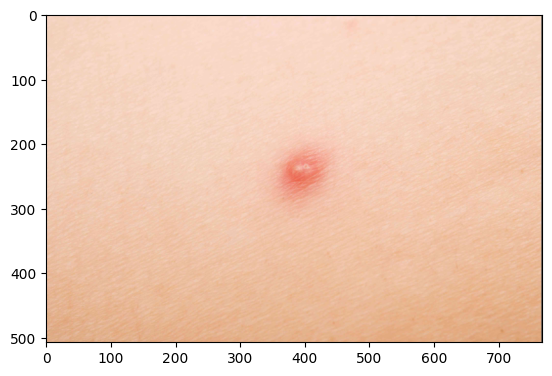

Benign


In [12]:
#Testing image from web - No Melanoma
model = SkinLesions()
model.load_state_dict(torch.load('/content/drive/MyDrive/Skin_lesions_project/model_weights.pth'))
model.eval()

image_path = '/content/drive/MyDrive/Skin_lesions_project/pimple.png' #Sample image from the web (acnae on the skin)
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.show()
transform = transforms.Compose([
            transforms.Resize((200, 200)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
image = transform(image)

with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, predicted = torch.max(output, 1)
    if predicted.item() == 1:
      print('Melanoma')
    else:
      print('Benign')